In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station= Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# View the measurement table 
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [10]:
# View the Station table 
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [11]:
# inspect engine to be able to find column names for Measurement class
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Find column names with list conprehension in Station class
columns = inspector.get_columns('Station')
[[(c['name'], c['type'])] for c in columns]
    

[[('id', INTEGER())],
 [('station', TEXT())],
 [('name', TEXT())],
 [('latitude', FLOAT())],
 [('longitude', FLOAT())],
 [('elevation', FLOAT())]]

In [14]:
# Find the most recent date in the data set.
most_recent_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

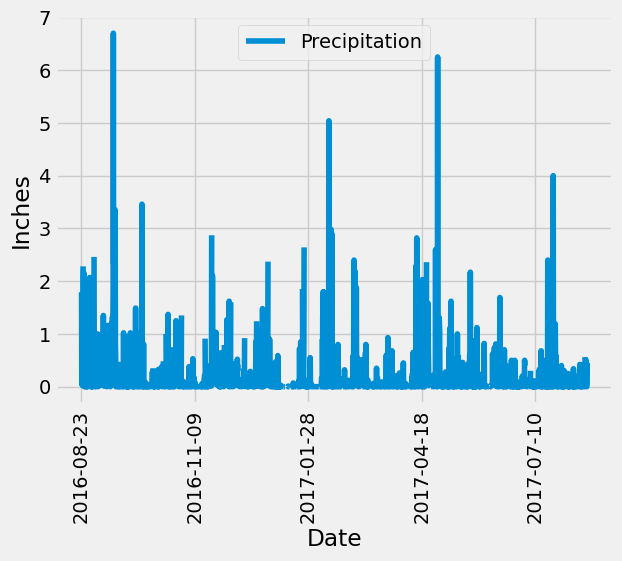

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
from dateutil.relativedelta import relativedelta
one_yr_ago_date= dt.date(2017,8,23) - relativedelta(years=+1)

# Perform a query to retrieve the data and precipitation scores
date_prcp= session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date>= one_yr_ago_date).all()
    
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df=pd.DataFrame(date_prcp)
df = df.rename(columns={'date': 'Date', 'prcp': 'Precipitation'})

# Sort the dataframe by date
sorted_df=df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(x='Date',y='Precipitation')
plt.xticks(rotation='vertical')
plt.ylabel('Inches')
plt.show()


In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df[['Precipitation']].describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
num_stations= session.query(Station).group_by(Station.station).count()
num_stations

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
    

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

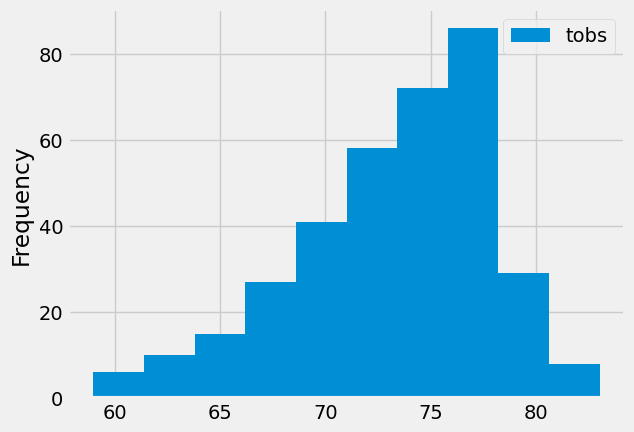

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_yr_ago_date= dt.date(2017,8,23) - relativedelta(years=+1)
temp_data=session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date>= one_yr_ago_date).\
    filter(Measurement.station=='USC00519281').all()
#find the most recent date at given station
#Put filtered data into dataframe and sort by date
temp_df=pd.DataFrame(temp_data)
temp_sorted_df=temp_df.sort_values('date')
temp_sorted_df.head()

# Plot the Data
temp_sorted_df.plot(x='date',y='tobs',kind='hist')

# Close Session

In [21]:
# Close Session
session.close()